## **Advanced RAG on UET  documentation using LangChain**

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt 

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

### **Load your knowledge base**

In [2]:
from langchain_community.document_loaders import PyMuPDFLoader
loader = PyMuPDFLoader("./UET_Lahore.pdf")
data = loader.load()

### **Split your knowledge base input chunck**

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in data:
    docs_processed += text_splitter.split_documents([doc])

- Now its time to make the embadding of all the chunck 
- We also have to keep in mind that when embedding documents, we will use an embedding model that accepts a certain maximum sequence length max_seq_length.
- So we should make sure that our chunk sizes are below this limit because any longer chunk will be truncated before processing, thus losing relevancy.


Model's maximum sequence length: 512


  0%|          | 0/478 [00:00<?, ?it/s]

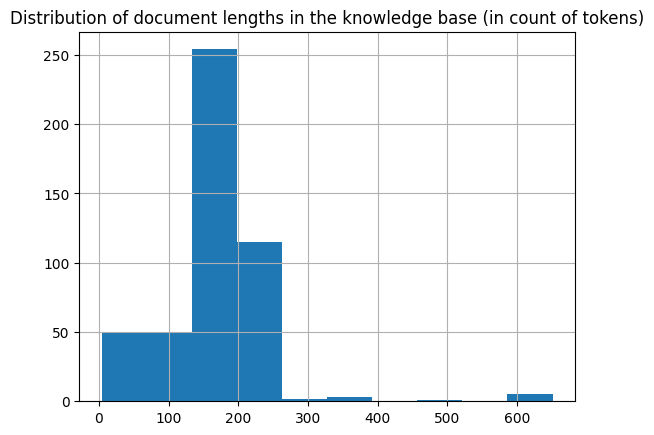

In [7]:
from sentence_transformers import SentenceTransformer
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

- As you can see, the chunk lengths are not aligned with our limit of 512 tokens, and some documents are above the limit, thus some part of them will be lost in truncation!
- So we should change the RecursiveCharacterTextSplitter class to count length in number of tokens instead of number of characters.
- Then we can choose a specific chunk size, here we would choose a lower threshold than 512:
- smaller documents could allow the split to focus more on specific ideas.
- But too small chunks would split sentences in half, thus losing meaning again: the proper tuning is a matter of balance.

  0%|          | 0/336 [00:00<?, ?it/s]

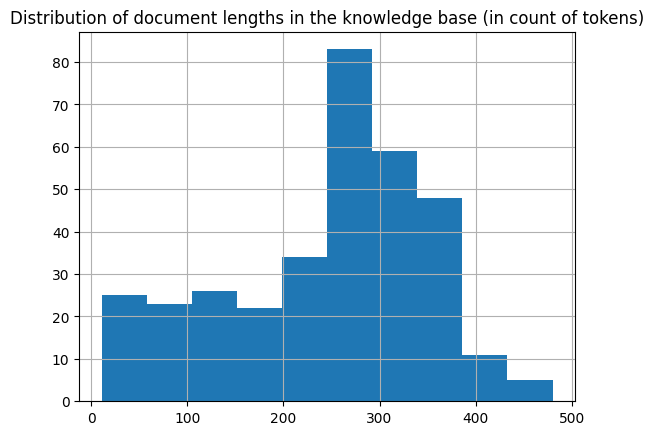

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
def split_documents(chunk_size: int,knowledge_base,tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME):
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10), # tis is the overlap between chunks in tokens (10%) 
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )
    docs_processed = [] # List of processed documents
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])
    # Remove duplicates 
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)
    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    data,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)
# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show() 

In [12]:
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
print(f"Number of documents in the knowledge base: {len(docs_processed)}")
print(lengths)  # Display the lengths of the first 5 documents

  0%|          | 0/336 [00:00<?, ?it/s]

Number of documents in the knowledge base: 336
[18, 76, 268, 12, 240, 66, 132, 292, 83, 300, 40, 175, 293, 263, 424, 458, 454, 431, 427, 437, 480, 463, 176, 389, 396, 199, 264, 280, 226, 275, 275, 83, 343, 373, 185, 368, 388, 242, 349, 340, 241, 349, 309, 222, 354, 271, 316, 344, 199, 340, 364, 277, 348, 353, 194, 347, 333, 41, 19, 291, 108, 363, 269, 296, 136, 289, 126, 283, 277, 234, 317, 60, 353, 92, 325, 339, 67, 285, 235, 119, 250, 171, 313, 104, 285, 255, 82, 260, 319, 166, 221, 234, 222, 125, 217, 229, 212, 310, 50, 260, 118, 359, 253, 244, 47, 324, 66, 320, 65, 258, 125, 266, 304, 323, 79, 320, 259, 261, 264, 166, 256, 193, 332, 38, 330, 211, 273, 291, 155, 266, 332, 303, 64, 298, 284, 73, 267, 11, 240, 217, 228, 24, 335, 344, 368, 136, 238, 246, 252, 92, 232, 247, 262, 120, 294, 294, 284, 52, 295, 161, 240, 219, 59, 319, 125, 316, 357, 156, 249, 234, 284, 303, 128, 397, 396, 250, 259, 259, 56, 305, 116, 310, 157, 279, 283, 258, 337, 154, 297, 281, 147, 266, 281, 270, 210, 329,

1.2 Building the vector database

In [15]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

- Retrieve the vectors and their corresponding documents: Extract the vectors and their associated metadata from the FAISS index.
- Print or visualize the data: Display the vectors and their metadata in a readable format.

In [22]:
# Retrieve the vectors and their corresponding documents
vectors = KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(0, KNOWLEDGE_VECTOR_DATABASE.index.ntotal)
metadata = KNOWLEDGE_VECTOR_DATABASE.index_to_docstore_id
for i, vector in enumerate(vectors):
    doc_id = metadata[i]
    doc = KNOWLEDGE_VECTOR_DATABASE.docstore.search(doc_id)
    print(f"Document ID: {doc_id}")
    print(f"Document Content: {doc.page_content}")  # Access the attribute directly
    print(f"Vector: {vector}")
    print("-" * 50)

Document ID: 59556710-a264-40f8-aee1-fb8a5fd09427
Document Content: Postgraduate Prospectus 2023 
 
 
www.uet.edu.pk 
 1
Vector: [-0.00874524  0.0415328   0.08610626 -0.02988632  0.00372484  0.0257583
  0.01123867  0.04779324  0.04156259  0.00387728 -0.001744   -0.11837251
  0.00267869 -0.0186176   0.05564125 -0.02581265 -0.02577825  0.00332334
 -0.0286302   0.0335983   0.08588649  0.01136745  0.00370481 -0.07415025
  0.04466326  0.00093155 -0.00736697 -0.02376456 -0.05045452 -0.18877582
  0.01300438 -0.05297816  0.01566334 -0.01834043 -0.01406411 -0.03375861
 -0.00973461  0.02077957 -0.03135686  0.04209354  0.01693261  0.0045307
 -0.03319256 -0.09554841 -0.02100964 -0.06884588 -0.01426191 -0.06716521
 -0.03232455 -0.05463307  0.03298049 -0.02763206  0.01493062  0.01209437
  0.00079355 -0.01453546  0.04896894  0.00238438 -0.03441986  0.0421782
  0.01482742  0.05060466 -0.2889775   0.06493527  0.06038538  0.04529473
  0.01160118 -0.02494027  0.05952978  0.0371365  -0.04214899  0.0231930

- to visualize the vectors, you can use libraries like matplotlib or seaborn to create plots. For example, to visualize the vectors in 2D space using PCA:



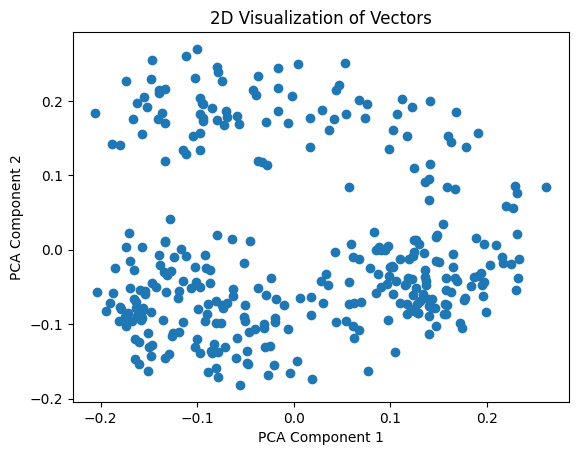

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Plot the vectors
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
plt.title("2D Visualization of Vectors")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

### **Now ask questions to the model**

In [24]:
# Embed a user query in the same space
user_query = "Who is Vice Chancellor University of Engineering and Technology, Lahore?"
query_vector = embedding_model.embed_query(user_query)

In [31]:
import pacmap # PaCMAP is a dimensionality reduction algorithm that preserves the global structure of the data
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

c:\Users\SONIC LAPTOPS\AppData\Local\Programs\Python\Python311\Lib\site-packages\pacmap\pacmap.py:822: UserWarning:




➡️ On the graph above, you can see a spatial representation of the knowledge base documents. As the vector embeddings represent the document's meaning, their closeness in meaning should be reflected in their embedding's closeness.

The user query's embedding is also shown: we want to find the k documents that have the closest meaning, thus we pick the k closest vectors.

In the LangChain vector database implementation, this search operation is performed by the method vector_database.similarity_search(query).

Here is the result:

In [70]:
retriever = KNOWLEDGE_VECTOR_DATABASE.as_retriever(search_kwargs={"k": 2}) # Retrieve the top 5 documents
docs = retriever.invoke("Who is Vice Chancellor University of Engineering and Technology, Lahore?") # Query the retriever with a user query
print("\n==================================Top document==================================")
print(docs[0].page_content)
print("==================================Metadata==================================")
print(docs[0].metadata) 


==================================Top document==================================
Governor Punjab 
 
Chancellor University of Engineering & Technology, Lahore
==================================Metadata==================================
{'source': './UET_Lahore.pdf', 'file_path': './UET_Lahore.pdf', 'page': 2, 'total_pages': 143, 'format': 'PDF 1.7', 'title': '', 'author': 'Admission Cell', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Word for Microsoft 365', 'producer': 'Microsoft® Word for Microsoft 365', 'creationDate': "D:20230717104647+05'00'", 'modDate': "D:20230717104647+05'00'", 'trapped': '', 'start_index': -1}


## **Now its time to load the Model and pass the constext with the Question**

In [54]:
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
READER_MODEL_NAME = "openai-community/gpt2-medium"
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)
# Create a HuggingFace pipeline
hf_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)
# Initialize the langchain LLM with the HuggingFace pipeline
READER_LLM = HuggingFacePipeline(pipeline=hf_pipeline)

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

c:\Users\SONIC LAPTOPS\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning:

The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.



### **Question without Context**

In [56]:
READER_LLM.invoke(user_query) # Query the LLM with a user query

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n\xa0The university has been established in 1872 by the British government to provide a comprehensive education for its citizens. The school was founded on May 1st 1893 as an institution dedicated solely towards engineering training. It now offers over 200 degrees including Bachelor\'s degree, Master Degree (Masters), Doctorate Degree(Doctoral) and Ph.D.(Phd). In addition there are various other programs such As Science Education Program, International Studies Programme, Art & Design School, Music Institute, etc. There are also many institutes which offer courses like Computer Programming Course, Electrical Engineer course or even Physics Courses. \xa0\xa0\xa0\xa0 \xa0In this article I will explain how you can get your hands dirty with computer programming at UET!\n\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0\xa0 This tutorial explains about some basic concepts that we need before starting any project related to computers. We have already covered al

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.
We give it our context and the user's question.

In [80]:
!pip show langchain

Name: langchain
Version: 0.2.1
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: C:\Users\SONIC LAPTOPS\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: aiohttp, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: langchain-community, llama-index


In [78]:
from langchain.prompts import PromptTemplate
# Combine the prompt format into a single string
prompt_template_str = """
System: Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
If the answer cannot be deduced from the context, do not give an answer.
User: Context:
{context}
---
Now here is the question you need to answer.
Question: {question}
"""
RAG_PROMPT_TEMPLATE = PromptTemplate(template=prompt_template_str)
print(RAG_PROMPT_TEMPLATE)

input_variables=['context', 'question'] template='\nSystem: Using the information contained in the context,\ngive a comprehensive answer to the question.\nRespond only to the question asked, response should be concise and relevant to the question.\nIf the answer cannot be deduced from the context, do not give an answer.\nUser: Context:\n{context}\n---\nNow here is the question you need to answer.\nQuestion: {question}\n'


## **Now Test the Modal with the Question**

In [79]:
context = "\n".join([doc.page_content for doc in docs])
final_prompt = RAG_PROMPT_TEMPLATE.format(context=context, question=user_query)
print(final_prompt)


System: Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
If the answer cannot be deduced from the context, do not give an answer.
User: Context:
Governor Punjab 
 
Chancellor University of Engineering & Technology, Lahore
Postgraduate Prospectus 2023 
 
 
www.uet.edu.pk 
 5  
 
 
UNIVERSITY OF ENGINEERING AND TECHNOLOGY LAHORE 
 
 
 
 
 
 
 
Chancellor 
 
MUHAMMAD BALIGH-UR-REHMAN 
 
Governor of Punjab 
 
 
 
Vice Chancellor 
 
PROF. DR. HABIB UR REHMAN 
 
 
 
Registrar 
 
MUHAMMAD ASIF 
 
 
 
Controller of Examinations 
 
MUHAMMAD ZARGHAM NUSRAT 
 
 
 
Treasurer  
 
IMRAN BABAR
---
Now here is the question you need to answer.
Question: Who is Vice Chancellor University of Engineering and Technology, Lahore?



In [76]:
# Format the retrieved documents into the context
context = "\n".join([doc.page_content for doc in docs])
final_prompt = RAG_PROMPT_TEMPLATE.format(context=context, question=user_query)
answer = READER_LLM(final_prompt)
print(answer)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Answer : The name "UET" means university or institute for engineering education. It has been used as title since 1857 by British authorities (see below). In Pakistan it was called UITL until 1971 where it became known under its current form - UNI. This institution had no official position prior till 1972 but continued to function with some autonomy during that period. Since then there have been several changes including appointment of new vice presidents who are appointed on merit according their performance record. After this change all institutions were renamed into one single entity which now stands at UNIVERSITIES, except those mentioned above whose names remain unchanged even after these reforms. As per our definition we can say they still exist today because each department within them carries out research related to various subjects such e., physics, chemistry etc.. We refer also back again through time to previous universities like DUKE COLLEGE FOR PHYSICS OR THE INSTITUTE OF B